![Atmospheric Toolbox](https://atmospherictoolbox.org/media/filer_public_thumbnails/filer_public/6d/35/6d35dffd-43f1-43ec-bff6-5aa066c8aabc/toolbox-header.jpg__1080x416_q85_subsampling-2.jpg)

# Atmospheric Toolbox - HARP comparison

This practical will show you how to compare Sentinel-5P satellite data against ground based data by making use of the [ESA Atmospheric Toolbox](https://atmospherictoolbox.org/).
In this exercise we will be focusing primarily on HARP as the toolset to do this.

We will use Sentinel-5P Level2 NO2 data and compare this against both a MAXDOAS and Pandora instrument that is located in Athens, Greece.
Both MAXDOAS and Pandora are DOAS instruments. MAXDOAS is a MAXDOAS type instrument and Pandora uses the DirectSun approach.

You can find an explanation on the different measurement techniques on the [FRM4DOAS website](https://frm4doas.aeronomie.be/index.php/project-overview/doas)
![doas-techniques](https://frm4doas.aeronomie.be/ProjectDir/doasinstruments.png)

The main difference to be aware of is the altitude range for which the measurements are applicable.

The MAXDOAS measurements only provide information on the troposphere, so we will use this data to compare against the tropospheric NO2 column information from S5P (`tropospheric_NO2_column_number_density` variable).

The Pandora measurements, on the other hand, provide information on the total column. So we will use that data to compare against the total NO2 column from S5P (`NO2_column_number_density` variable).

For this exercise we will look at data from February 2020.

The Sentinel-5P data was retrieved from the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home).

The MAXDOAS data was retrieved from [NDACC](http://www.ndaccdemo.org) and the Pandora data from [Pandonia](https://www.pandonia-global-network.org). Both datasets are also available through [EVDC](https://evdc.esa.int).

## S5P vs. MAXDOAS NO2 comparison

In order to perform a comparison for the full month of February 2020, we would need a full month of Sentinel-5P data.
Even if we already filter for only those products that have data over Athens, we would still end up with about 48 orbits (note that, because orbits slightly overlap, we have multiple overpasses within a single day for some days).

Since we are only interested in the data around Athens, we ideally don't want keep the full 450MB for each L2 product, but only the satellite data around the area.

A convenient first step is therefore to create so-called _overpass files_. We can do this with HARP, by providing a geographic filter on the location of the MAXDOAS instrument, which is at 38.05 latitude and 23.86 longitude.

As an example we will perform such a filter on the NO2 data from the regridding exercise from yesterday (which was data from 15 September 2020).

In [1]:
import csv
import datetime
import harp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import cartopy.crs as ccrs

In [2]:
filename = "../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T002200_20200915T020329_15147_01_010302_20200916T170359.nc"
# since the area_covers_point filter is quite slow, we add some explicit filters
# on latitude (which is fast) to already exclude a large part of the product
operations = "latitude>36;latitude<40;area_covers_point(38.05, 23.86)"
try:
    overpass = harp.import_product(filename, operations)
except harp.NoDataError:
    print('No overpasses found')

No overpasses found


We see that this product did not contain any matches. If that happens you get an error which you can catch using this `try`/`catch` approach.

If we try this filter for a product that actually does contain an overpass we get:

In [3]:
filename = "../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc"
operations = "latitude>36;latitude<40;area_covers_point(38.05, 23.86)"
try:
    overpass = harp.import_product(filename, operations)
except harp.NoDataError:
    print('No overpasses found')
print(overpass)

source product = 'S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc'
history = "2020-11-16T12:17:13Z [harp-1.12] harp.import_product('../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc',operations='latitude>36;latitude<40;area_covers_point(38.05, 23.86)')"

int scan_subindex {time=1}
double datetime_start {time=1} [seconds since 2010-01-01]
float datetime_length [s]
int orbit_index
long validity {time=1}
float latitude {time=1} [degree_north]
float longitude {time=1} [degree_east]
float latitude_bounds {time=1, 4} [degree_north]
float longitude_bounds {time=1, 4} [degree_east]
float sensor_latitude {time=1} [degree_north]
float sensor_longitude {time=1} [degree_east]
float sensor_altitude {time=1} [m]
float solar_zenith_angle {time=1} [degree]
float solar_azimuth_angle {time=1} [degree]
float sensor_zenith_angle {time=1} [degree]
float sensor_azimuth_angle {time=1} [degree]
doub

You can see that we only got one measurement for each variable.

Instead of reading this data in Python, we actually want to have this data stored as a file on disk.
This allows us to reuse it later as input for our comparisons (and we can then throw away the original L2 products).

To do this we could use a combination of `harp.import_product()` and `harp.export_product()` in Python.
However, it is actually faster to call the `harpconvert` tool from the command line.

You can call command line tools from within a python notebook by prefixing the command with a `!`.
This is an IPython features that is described in the [documentation](https://ipython.readthedocs.io/en/stable/interactive/python-ipython-diff.html#shell-assignment).
We will use this several times in this exercise.

Be aware that the commands that we will execute are Linux-style commands which will work on Linux and macOS, but may not work on Windows (without some modification to path references and/or usage of quotes).

To convert the product using `harpconvert` we can use:

In [4]:
!harpconvert -a "latitude>36;latitude<40;area_covers_point(38.05, 23.86)" ../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc s5p_l2_no2_15153_athens.nc

And we can then read in this overpass file in Python using:

In [5]:
overpass = harp.import_product("s5p_l2_no2_15153_athens.nc")
print(overpass)

source product = 'S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc'
history = "2020-11-16T12:17:26Z [harp-1.12] harpconvert -a 'latitude>36;latitude<40;area_covers_point(38.05, 23.86)' ../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc s5p_l2_no2_15153_athens.nc"

int scan_subindex {time=1}
double datetime_start {time=1} [seconds since 2010-01-01]
float datetime_length [s]
int orbit_index
long validity {time=1}
float latitude {time=1} [degree_north]
float longitude {time=1} [degree_east]
float latitude_bounds {time=1, 4} [degree_north]
float longitude_bounds {time=1, 4} [degree_east]
float sensor_latitude {time=1} [degree_north]
float sensor_longitude {time=1} [degree_east]
float sensor_altitude {time=1} [m]
float solar_zenith_angle {time=1} [degree]
float solar_azimuth_angle {time=1} [degree]
float sensor_zenith_angle {time=1} [degree]
float sensor_azimuth_angle {time=1} [degr

Note that the product contains a `history` attribute that shows how HARP generated the file.
HARP will include such history information in each file that it writes, which is very useful for traceability.

In [6]:
print(overpass.history)

2020-11-16T12:17:26Z [harp-1.12] harpconvert -a 'latitude>36;latitude<40;area_covers_point(38.05, 23.86)' ../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc s5p_l2_no2_15153_athens.nc


For the month of February we already created such overpass files for you, which are available in the `../eodata/sentinel5p/overpass/no2/athens` directory. These files are actually the official overpass files that are used by the [Sentinel-5P Mission Performance Center Validation Facility](http://mpc-vdaf.tropomi.eu).

These files contain not just the pixel over Athens itself, but also a range of pixels around that area. This allows the validation experts to investigate other criteria such as the spatial homogeneity of the data.

In [7]:
filename = "../eodata/sentinel5p/overpass/no2/athens/S5P_OFFL_L2VONO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211_athens.nc"
overpass_11932 = harp.import_product(filename)
print(overpass_11932)

source product = 'S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc'
history = "2020-02-10T16:48:45Z [vdafop-1.8.0] vdafop S5P_OPER_CFG_VDAFOP_00000000T000000_99999999T999999_20191001T140933.EOF S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc\n2020-02-10T16:48:45Z [harp-1.5] harpconvert -a 'point_in_area((39.336,39.312,39.238,39.119,38.958,38.762,36.558,36.193,36.295,36.588,38.762,38.958,39.119,39.238,39.312),(23.775,24.104,24.422,24.714,24.972,25.184,27.145,26.875,20.598,20.385,22.365,22.577,22.835,23.127,23.445))' S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc S5P_OFFL_L2VONO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211_athens.nc"

int scan_subindex {time=2735}
double datetime_start {time=2735} [seconds since 2010-01-01]
float datetime_length [s]
int orbit_index
long validity {time=2735}
float latitude {time=2735} [degree_north]
float longitude {t

As you can see from the `history` attribute this overpass file was just a filtering of the original proudct using a polygon area; no other HARP operations were performed.

We can use the `harp_l2geoscatterplot` from the regridding exercise from yesterday to plot this overpass data:

In [8]:
def harp_l2geoscatterplot(product, value, colorrange=None, colortable='jet', size=1):
    variable = product[value]
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.scatter(product.longitude.data, product.latitude.data, c=variable.data, 
                      vmin=vmin, vmax=vmax, cmap=colortable, s=size, transform=ccrs.PlateCarree())

    ax.coastlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

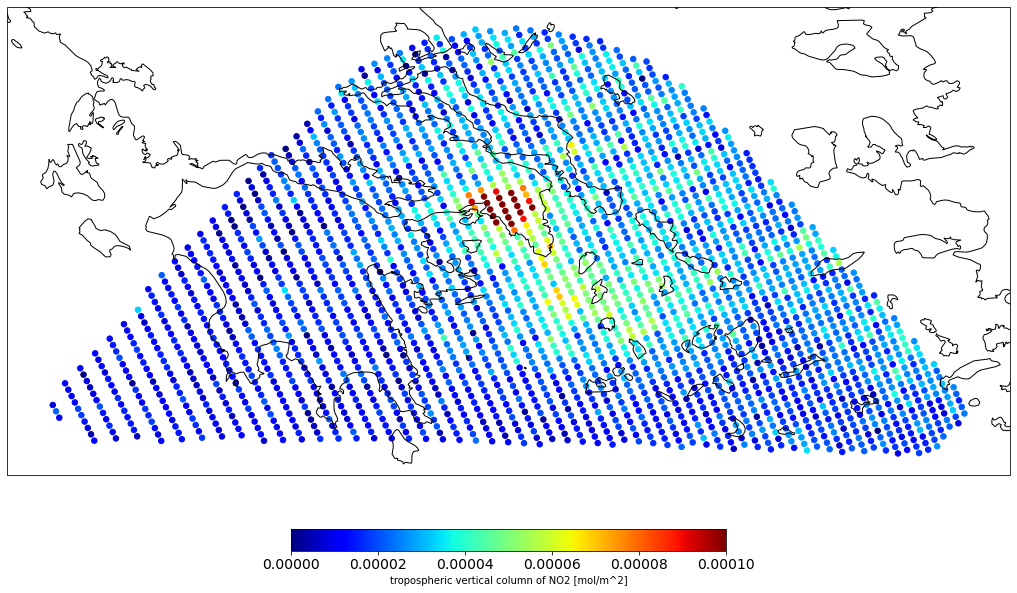

In [9]:
harp_l2geoscatterplot(overpass_11932, 'tropospheric_NO2_column_number_density', colorrange=(0,0.0001), size=30)

Now that we have the satellite data, we can start collocating the data with the MAXDOAS data.

What we want, is to know which satellite measurements match up in time and space with which MAXDOAS measurements.

The `harpcollocate` command line tool is designed to answer this question. It will take distance criteria on e.g. time and space and produce a list of pairs of measurements where the satellite and reference data match.

You can get a quick help reference by passing the `--help` argument to the harpcollocate tool.

In [10]:
!harpcollocate --help

Usage:
    harpcollocate [options] <path-a> <path-b> <outputpath>
        Find matching sample pairs between two datasets of HARP files.
        The path for a dataset can be either a single file or a directory
        containing files. The results will be written as a comma separated
        value (csv) file to the provided output path.
        If a directory is specified then all files (recursively) from that
        directory are used for a dataset.
        If a file is a .pth file then the file paths from that text file
        (one per line) are used. These file paths can be absolute or
        relative and can point to files, directories, or other .pth files.

        Options:
            -d '<diffvariable> <value> [unit]'
                Specifies a collocation criterium.
                Only include pairs where the absolute difference between the
                values of the given variable for dataset A and B are
                less/equal than the given value.
               

As a time distance criterium we are interested in measurements that are only half an hour apart. And for the spatial distance, we are only interested on satellite pixels that are directly over the MAXDOAS instrument.

The command with this criteria will then be:

In [11]:
!harpcollocate -d "datetime 0.5 [h]" --point-in-area-yx ../eodata/sentinel5p/overpass/no2/athens ../eodata/groundbased/maxdoas/athens collocations_maxdoas_full.csv

This command produced a `csv` file called `collocations_maxdoas_full.csv` that contains the matching pairs.

In [12]:
with open('collocations_maxdoas_full.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
       print(', '.join(row))

collocation_index, source_product_a, index_a, source_product_b, index_b, datetime_diff [h]
0, S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc, 1450403, groundbased_uvvis.doas.offaxis.no2_iup008_athens_20200201t062127z_20200215t125518z_001.hdf, 8, 0.28686417
1, S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc, 1450403, groundbased_uvvis.doas.offaxis.no2_iup008_athens_20200201t062127z_20200215t125518z_001.hdf, 9, 0.039664167
2, S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc, 1450403, groundbased_uvvis.doas.offaxis.no2_iup008_athens_20200201t062127z_20200215t125518z_001.hdf, 10, -0.20753583
3, S5P_OFFL_L2__NO2____20200201T112236_20200201T130406_11933_01_010302_20200204T163837.nc, 1417498, groundbased_uvvis.doas.offaxis.no2_iup008_athens_20200201t062127z_20200215t125518z_001.hdf, 12, 0.23090444
4, S5P_OFFL_L2__NO2____20200201T112236_20200201T130406_11933_01_010302_20200204T1

What you will see on each line is:
- a unique identifier of the collocation pair (the `collocation_index`)
- a reference to the satellite product
- an index of the measurement within the satellite product
- a reference to the maxdoas product
- an index of the measurement within the maxdoas product
- the distance (in time) between the two measurements

Note that the reference to the satellite product is the orginal L2 product. Also, the 'index' of the satellite measurement is the index of the pixel in the original L2 product (this index value is stored as an `index` variable in the overpass file).
The advantage of this, is that you can get the measurement directly from the original L2 product again without having to have access to the overpass file.
All the operations we perform below on the overpass files using this collocation result file can actually also still be performed on the original L2 products as well. This makes it easy to share a collocation result file with someone else who doesn't have your overpass files. That person can then download the original products and use the collocation result file to quickly extract the collocated measurements.

We can see in the list that sometimes the same satellite measurement appears twice (e.g. `S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc` measurement `1450403`). This is because within the the given half hour time distance there are multiple MAXDOAS measurements that match that criteria.

We can instruct HARP to only take the nearest MAXDOAS measurement in that case by providing the `-nx datetime` option to `harpcollocate`.

Also, the collocations that we produced were actually not filtered for quality. We actually only want measurements that are 'of good quality'.
For the S5P data this means applying the `tropospheric_NO2_column_number_density_validity > 75` filter (as we have seen in the exercise from yesterday) and for MAXDOAS we are only going to filter out NaN values (which can be done using the `valid(tropospheric_NO2_column_number_density)` filter.

We can pass these filters as part of the `harpcollocate` command line using the `-aa` and `-ab` parameters.

If we add the `-nx` and `-aa` and `-ab` options we get:

In [13]:
!harpcollocate -d "datetime 0.5 [h]" --point-in-area-yx -nx datetime -aa "tropospheric_NO2_column_number_density_validity > 75" -ab "valid(tropospheric_NO2_column_number_density)" ../eodata/sentinel5p/overpass/no2/athens ../eodata/groundbased/maxdoas/athens collocations_maxdoas.csv

Now that we know which measurements pair up, we need to filter both the satellite data and the MAXDOAS data to provide us the data for those pairs.

We do this by using the `collocate_left()` and `collocate_right()` HARP operations. The `collocate_left()` filters based on the information that is on the _left_ for each pair (i.e. the satellite data) and `collocate_right()` the information that is on the _right_ (i.e. the MAXDOAS data).

In addition, we need to add several other operations that allow us to make sure that variables have the same units for both the satellite and maxdoas data.

In [14]:
filepattern = "../eodata/sentinel5p/overpass/no2/athens/*"
operations = ';'.join([
    'collocate_left("collocations_maxdoas.csv")',
    'derive(datetime {time} [days since 2000-01-01])',
    'derive(tropospheric_NO2_column_number_density [Pmolec/cm2])',
    'derive(tropospheric_NO2_column_number_density_uncertainty {time} [Pmolec/cm2])',
    'sort(collocation_index)',
])
s5p = harp.import_product(filepattern, operations)

filepattern = "../eodata/groundbased/maxdoas/athens/*"
operations = ';'.join([
    'collocate_right("collocations_maxdoas.csv")',
    'derive(datetime {time} [days since 2000-01-01])',
    'derive(tropospheric_NO2_column_number_density [Pmolec/cm2])',
    'derive(tropospheric_NO2_column_number_density_uncertainty {time} [Pmolec/cm2])',
    'sort(collocation_index)',
])
maxdoas = harp.import_product(filepattern, operations)

You will see that the imported s5p and maxdoas data now contain the same amount of measurements. And by sorting both datasets by the `collocation_index` we make sure that all the measurements are nicely aligned.

In [15]:
print(s5p)
print(maxdoas)

history = '2020-02-10T16:48:45Z [vdafop-1.8.0] vdafop S5P_OPER_CFG_VDAFOP_00000000T000000_99999999T999999_20191001T140933.EOF S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc\n2020-02-10T16:48:45Z [harp-1.5] harpconvert -a \'point_in_area((39.336,39.312,39.238,39.119,38.958,38.762,36.558,36.193,36.295,36.588,38.762,38.958,39.119,39.238,39.312),(23.775,24.104,24.422,24.714,24.972,25.184,27.145,26.875,20.598,20.385,22.365,22.577,22.835,23.127,23.445))\' S5P_OFFL_L2__NO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211.nc S5P_OFFL_L2VONO2____20200201T094106_20200201T112236_11932_01_010302_20200204T143211_athens.nc\n2020-11-16T12:17:43Z [harp-1.12] harp.import_product(\'../eodata/sentinel5p/overpass/no2/athens/*\',operations=\'collocate_left("collocations_maxdoas.csv");derive(datetime {time} [days since 2000-01-01]);derive(tropospheric_NO2_column_number_density [Pmolec/cm2]);derive(tropospheric_NO2_column_number_density_uncertainty {t

We can now plot the s5p and maxdoas data side-by-side

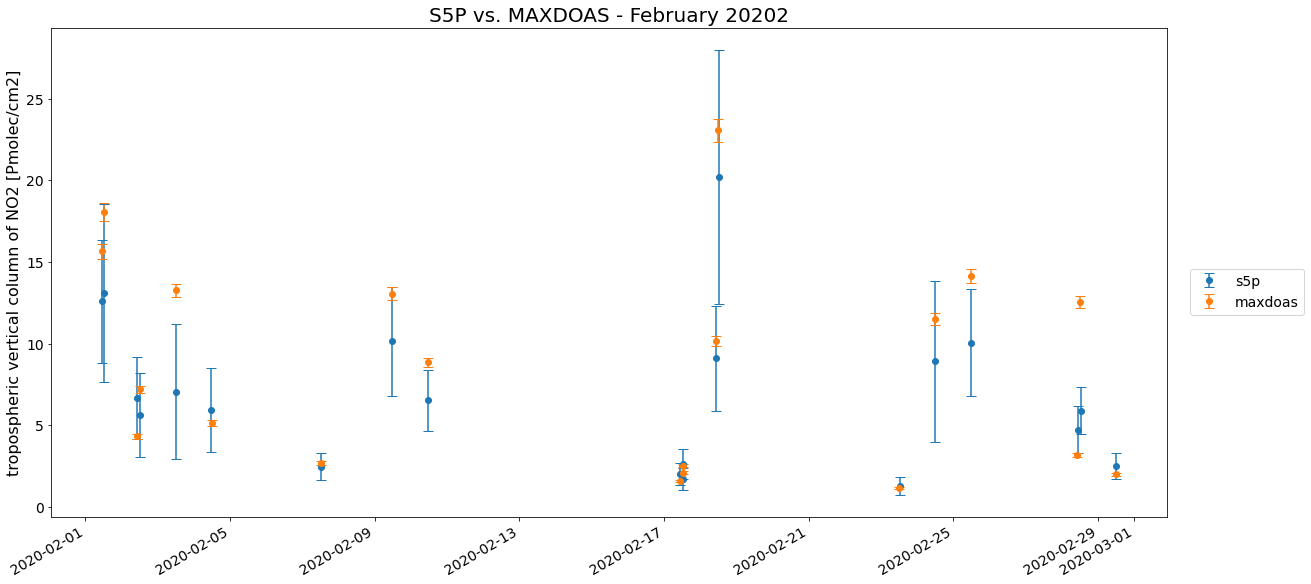

In [16]:
fig = plt.figure(figsize=(20, 10))

plt.title("S5P vs. MAXDOAS - February 20202", fontsize=20)

t = [datetime.datetime(2000,1,1) + datetime.timedelta(x) for x in s5p.datetime.data]
plt.errorbar(t, s5p.tropospheric_NO2_column_number_density.data,
             yerr=s5p.tropospheric_NO2_column_number_density_uncertainty.data,
             fmt='o', capsize=5, label="s5p")

t = [datetime.datetime(2000,1,1) + datetime.timedelta(x) for x in maxdoas.datetime.data]
plt.errorbar(t, maxdoas.tropospheric_NO2_column_number_density.data,
             yerr=maxdoas.tropospheric_NO2_column_number_density_uncertainty.data,
             fmt='o', capsize=5, label="maxdoas")

fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(f'{s5p.tropospheric_NO2_column_number_density.description} [{s5p.tropospheric_NO2_column_number_density.unit}]',
           fontsize=16)

fig.legend(loc='right', prop={'size': 14})

plt.show()

We can also plot the difference. This can be done using:

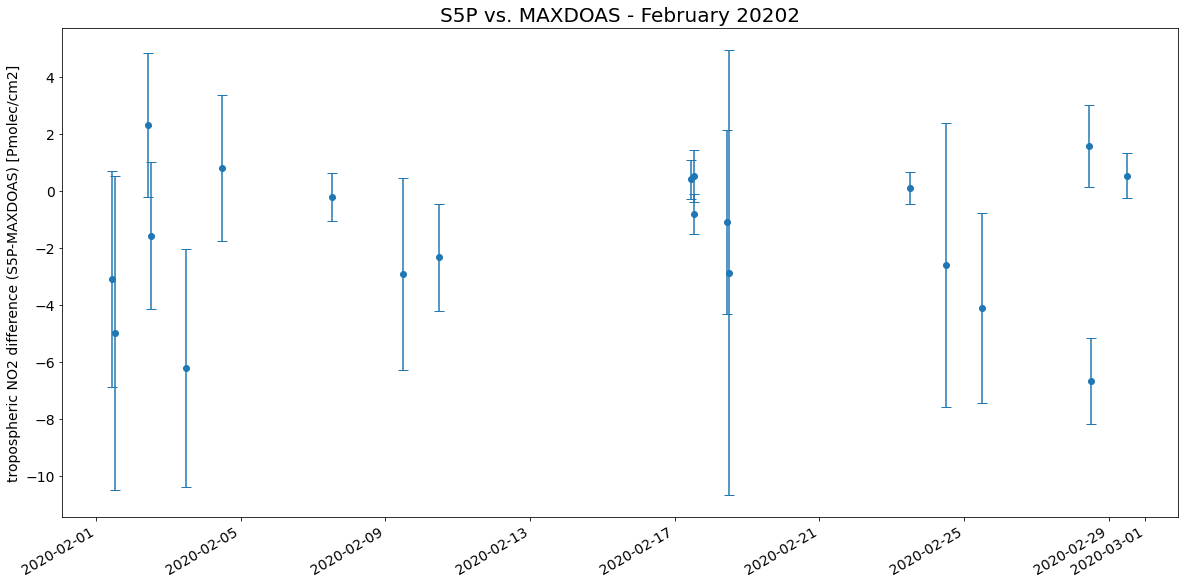

In [17]:
fig = plt.figure(figsize=(20, 10))

plt.title("S5P vs. MAXDOAS - February 20202", fontsize=20)

t = [datetime.datetime(2000,1,1) + datetime.timedelta(x) for x in s5p.datetime.data]
diff = s5p.tropospheric_NO2_column_number_density.data - maxdoas.tropospheric_NO2_column_number_density.data
# propagate uncertainty by taking the squared sum of the invidual uncertainties of s5p and maxdoas
err = np.sqrt(s5p.tropospheric_NO2_column_number_density_uncertainty.data**2 + maxdoas.tropospheric_NO2_column_number_density_uncertainty.data**2)
plt.errorbar(t, diff, yerr=err, fmt='o', capsize=5, label="s5p - maxdoas")

fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(f'tropospheric NO2 difference (S5P-MAXDOAS) [{s5p.tropospheric_NO2_column_number_density.unit}]',
           fontsize=14)

plt.show()

This comparison is actually also available on the [Validation Server](https://mpc-vdaf-server.tropomi.eu) that is used by the S5P Mission Performance center.

You can compare the results by looking at the [report for NO2 MAXDOAS for Athens](https://mpc-vdaf-server.tropomi.eu/no2/no2-offl-maxdoas/athens). If, on that page, you click on the 'Select Date Range' on the top right, and then select the 'Month' results for 2020 Feb, you should see the same results as in the plots above. 

## S5P vs. Pandora NO2 comparison

**EXERCISE**: extend this notebook by performing a comparison and creating plots for S5P vs. Pandora.

You should use the same steps of running a `harpcollocate` and then importing the S5P and Pandora data using the `collocate_left()` and `collocate_right()` operations. The collocation criteria are the same (i.e. measurements within half an hour, Pandora points in satellite pixel area, and select nearest Pandora in time for each satellite measurement).

Some differences to take into account:
- You need to use `NO2_column_number_density` wherever we used `tropospheric_NO2_column_number_density`
- You need to use `NO2_column_number_density_uncertainty` wherever we used `tropospheric_NO2_column_number_density_uncertainty`
- The Pandora data can be found in `../eodata/groundbased/pandora/athens`
- You will still need to filter the S5P data based on `tropospheric_NO2_column_number_density_validity` (even if we use the total column)
- The official filter for the Pandora data is: `NO2_column_number_density_validity!=1;NO2_column_number_density_validity!=2;NO2_column_number_density_validity!=11;NO2_column_number_density_validity!=12`
- Use `collocations_pandora.csv` as the filename for the collocation results

Be aware that the collocation with Pandora takes a bit longer, because there is a lot more Pandora measurements available within a month.

You can compare your final graphs by looking at the [report for Pandora on the Validation Server](https://mpc-vdaf-server.tropomi.eu/no2/no2-offl-pandora/athens).
Be aware that the results will be slightly different. This is because the comparison on the Validation Server uses an average of all Pandora measurements that match a satellite measurement (instead of taking the nearest in time). But this averaging is an advanced step that we will not cover in this exercise.
